In [15]:
from nltk.lm import MLE, Laplace, Lidstone, StupidBackoff
from nltk import word_tokenize
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.corpus import brown
import json
import pytrec_eval
import re
import random

In [2]:
sentences = [" ".join(sentence).lower() for sentence in brown.sents(categories="news")]
sentences = [sentence.replace("\'\'", "") for sentence in sentences]
sentences = [sentence.replace("``", "") for sentence in sentences]

In [3]:
words_token = [list(map(str.lower, word_tokenize(sent))) for sent in sentences]
print(words_token[0])

['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', 'atlanta', "'s", 'recent', 'primary', 'election', 'produced', 'no', 'evidence', 'that', 'any', 'irregularities', 'took', 'place', '.']


In [10]:
n = 5
model = MLE(n)
train, padd_sent = padded_everygram_pipeline(n, words_token)
model.fit(train, padd_sent)

In [11]:
import numpy as np
pre_sent = []
word = []
with open('APPLING1DAT.643', 'r') as rd:
    for line in rd.readlines():
        if(line[0] == '$'):
            pass
        else:
            pair = line.strip().split()
            word.append(pair[1])
            pre_sent.append([" ".join(pair[2:]).split("*")[0].lower()])

In [32]:
score = {}
for n in [1,2,3,5,10]:
    model = MLE(n)
    train, padd_sent = padded_everygram_pipeline(n,words_token)
    model.fit(train,padd_sent)
    topN, qrel, qret = {}, {}, {}
    for p, correct in zip(pre_sent, word):
        dis = {}
        vocab = random.sample(word, len(word))
        for w in vocab:
            dis[w] = model.score(word=w, context=p )
        sorted_result = dict(sorted(dis.items(), key=lambda x: x[1]))
        topN[str(p)] = {k: sorted_result[k] for k in list(sorted_result)[:10]}

        qrel[str(p)] = {correct: 1}
        qret[str(p)] = topN[str(p)]

    metrics = {'success_1', 'success_5', 'success_10'}
    evaluator = pytrec_eval.RelevanceEvaluator(qrel, metrics)
    results = evaluator.evaluate(qret)
    avg_result = dict()
    for m in metrics:
        avg_result[m] = sum([v[m] for (k, v) in results.items()]) / len(results)
    score[n] = avg_result
    print(f'{n} => {avg_result}')


1 => {'success_1': 0.0, 'success_5': 0.0, 'success_10': 0.02962962962962963}
2 => {'success_1': 0.0, 'success_5': 0.022222222222222223, 'success_10': 0.02962962962962963}
3 => {'success_1': 0.014814814814814815, 'success_5': 0.044444444444444446, 'success_10': 0.11851851851851852}
5 => {'success_1': 0.022222222222222223, 'success_5': 0.044444444444444446, 'success_10': 0.08148148148148149}
10 => {'success_1': 0.0, 'success_5': 0.014814814814814815, 'success_10': 0.05925925925925926}


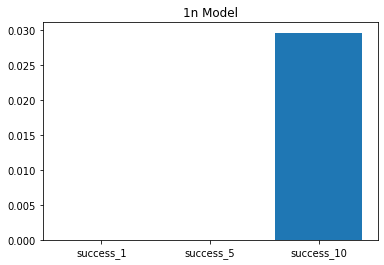

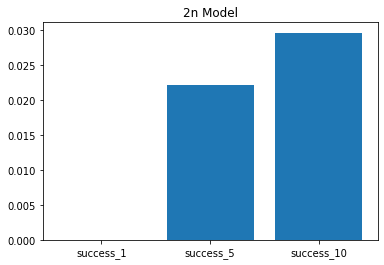

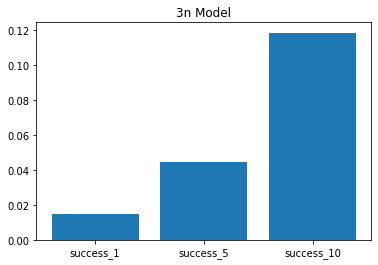

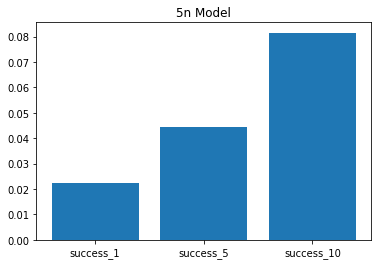

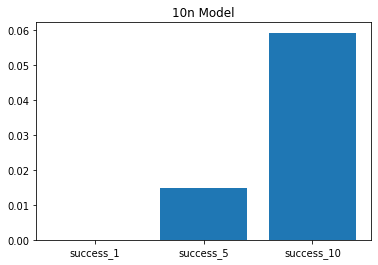

In [33]:
import matplotlib.pyplot as plt
for n, avg_result in zip(score.keys(), score.values()):
    plt.bar(avg_result.keys(), avg_result.values())
    plt.title(str(n)+"n Model")
    plt.show()